In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

#acquire
import acquire
from env import host, username, password
from pydataset import data
from sklearn.impute import SimpleImputer

# Acquire & Prep Data

## Acquire data - zillow_data()

In [2]:
df = acquire.zillow_data()

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        223 non-null    float64
 1   storytypeid                   50 non-null     float64
 2   propertylandusetypeid         77580 non-null  float64
 3   heatingorsystemtypeid         49572 non-null  float64
 4   buildingclasstypeid           15 non-null     float64
 5   architecturalstyletypeid      207 non-null    float64
 6   airconditioningtypeid         25007 non-null  float64
 7   parcelid                      77580 non-null  int64  
 8   id                            77580 non-null  int64  
 9   logerror                      77580 non-null  float64
 10  transactiondate               77580 non-null  object 
 11  id                            77580 non-null  int64  
 12  basementsqft                  50 non-null     float64
 13  b

## Prep Zillow Data - prepare_zillow()

In [4]:
df.propertylandusedesc.value_counts()

Single Family Residential                     52442
Condominium                                   19342
Duplex (2 Units, Any Combination)              2021
Planned Unit Development                       1947
Quadruplex (4 Units, Any Combination)           729
Triplex (3 Units, Any Combination)              539
Cluster Home                                    335
Mobile Home                                      74
Manufactured, Modular, Prefabricated Homes       59
Residential General                              42
Cooperative                                      29
Commercial/Office/Residential Mixed Used         15
Townhouse                                         6
Name: propertylandusedesc, dtype: int64

***
Single unit properties - Single Family Residential, Mobile Home, Manufactured, Modular, Prefabricated Homes, Townhouse
* Townhouse only has 6 so drop
***

In [5]:
# Restrict propertylandusedesc to those of single unit
df = df[(df.propertylandusedesc == 'Single Family Residential') | 
        (df.propertylandusedesc == 'Mobile Home') |
        (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes')]

In [6]:
# null values
df.isnull().sum()

typeconstructiontypeid          52499
storytypeid                     52528
propertylandusetypeid               0
heatingorsystemtypeid           18639
buildingclasstypeid             52575
architecturalstyletypeid        52505
airconditioningtypeid           38935
parcelid                            0
id                                  0
logerror                            0
transactiondate                     0
id                                  0
basementsqft                    52528
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           18783
calculatedbathnbr                 175
decktypeid                      52183
finishedfloor1squarefeet        48184
calculatedfinishedsquarefeet      102
finishedsquarefeet12              309
finishedsquarefeet13            52533
finishedsquarefeet15            52575
finishedsquarefeet50            48184
finishedsquarefeet6             52410
fips                                0
fireplacecnt

In [7]:
# dropping cols/rows where more than half of the values are null
df = acquire.handle_missing_values(df, col_perc = .5, row_perc = .5)

In [8]:
# dropping the columns with 17K missing values too much to fill/impute/drop rows
df = df.drop(columns=['heatingorsystemtypeid', 'buildingqualitytypeid', 'propertyzoningdesc', 'unitcnt', 'heatingorsystemdesc'])

In [9]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [10]:
# single outlier in transactiondate
df.transactiondate.sort_values(ascending=False)

77579    2018-05-25
77578    2017-09-25
77577    2017-09-21
77576    2017-09-21
77575    2017-09-20
            ...    
7        2017-01-01
6        2017-01-01
3        2017-01-01
2        2017-01-01
0        2017-01-01
Name: transactiondate, Length: 52575, dtype: object

In [11]:
df.transactiondate.describe()

count          52575
unique           258
top       2017-06-30
freq             814
Name: transactiondate, dtype: object

In [12]:
# address date outlier by replacing with mode
df['transactiondate'] = df.transactiondate.replace('2018-05-25', '2017-06-30')

In [13]:
# Convert transactiondate to datetime
df['transactiondate'] = pd.to_datetime(df.transactiondate)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52575 entries, 0 to 77579
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   propertylandusetypeid         52575 non-null  float64       
 1   parcelid                      52575 non-null  int64         
 2   id                            52575 non-null  int64         
 3   logerror                      52575 non-null  float64       
 4   transactiondate               52575 non-null  datetime64[ns]
 5   id                            52575 non-null  int64         
 6   bathroomcnt                   52575 non-null  float64       
 7   bedroomcnt                    52575 non-null  float64       
 8   calculatedbathnbr             52400 non-null  float64       
 9   calculatedfinishedsquarefeet  52473 non-null  float64       
 10  finishedsquarefeet12          52266 non-null  float64       
 11  fips                        

In [14]:
# drop assessment year as it is one single year
df = df.drop(columns=(['assessmentyear']))

In [15]:
#dropping the id columns, as parcelid is a unique identifier
df= df.drop(columns=('id'))

In [16]:
df.isnull().sum()

propertylandusetypeid              0
parcelid                           0
logerror                           0
transactiondate                    0
bathroomcnt                        0
bedroomcnt                         0
calculatedbathnbr                175
calculatedfinishedsquarefeet     102
finishedsquarefeet12             309
fips                               0
fullbathcnt                      175
latitude                           0
longitude                          0
lotsizesquarefeet                375
propertycountylandusecode          0
rawcensustractandblock             0
regionidcity                    1037
regionidcounty                     0
regionidzip                       27
roomcnt                            0
yearbuilt                        135
structuretaxvaluedollarcnt        96
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              2
taxamount                          4
censustractandblock              123
propertylandusedesc                0
d

In [17]:
# organize features with missing data by discrete & continuous in order to impute missing data
discrete_col = ['calculatedbathnbr', 'fullbathcnt', 'regionidcity', 'regionidzip', 'yearbuilt', 'censustractandblock']
cont_col = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']

In [18]:
# Split data
train, validate, test = acquire.split_continuous(df)

train -> (29442, 27)
validate -> (12618, 27)
test -> (10515, 27)


In [19]:
# impute mode on discrete columns in split data
imputer = SimpleImputer(strategy='most_frequent')
train[discrete_col] = imputer.fit_transform(train[discrete_col])
validate[discrete_col] = imputer.transform(validate[discrete_col])
test[discrete_col] = imputer.transform(test[discrete_col])

In [20]:
# impute mean on continuous columns in split data
imputer = SimpleImputer(strategy='mean')
train[cont_col] = imputer.fit_transform(train[cont_col])
validate[cont_col] = imputer.transform(validate[cont_col])
test[cont_col] = imputer.transform(test[cont_col])

In [21]:
#control test
test.isnull().sum()

propertylandusetypeid           0
parcelid                        0
logerror                        0
transactiondate                 0
bathroomcnt                     0
bedroomcnt                      0
calculatedbathnbr               0
calculatedfinishedsquarefeet    0
finishedsquarefeet12            0
fips                            0
fullbathcnt                     0
latitude                        0
longitude                       0
lotsizesquarefeet               0
propertycountylandusecode       0
rawcensustractandblock          0
regionidcity                    0
regionidcounty                  0
regionidzip                     0
roomcnt                         0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
censustractandblock             0
propertylandusedesc             0
dtype: int64

### Control check to make sure we've addressed nulls

In [22]:
train.shape, validate.shape, test.shape

((29442, 27), (12618, 27), (10515, 27))

***
Note: I acquired and prepped the data above but after reviewing my data and trying to game plan, I decide to pare down collinearity by eliminating redundant information
***

### FIPS data manipulation

In [46]:
# convert fips to integer to drop decimals before converting to string
df['fips'] = df['fips'].astype(int)

In [47]:
# convert fips data to string so that we can split
df['fips'] = df['fips'].astype('str')

In [52]:
# confirm
df.fips.dtype

dtype('O')

In [53]:
# Create County column by stripping state reference location(last three digits)
df['county'] = df['fips'].str[1:]

In [54]:
# check to see how many different counties
df.county.value_counts()

037    33966
059    14145
111     4464
Name: county, dtype: int64

In [55]:
# Replace numerics with labels
df['county'] = df['county'].replace({'037':'Los Angeles', '059':'Orange', '111':'Ventura'})

In [56]:
# control check on manipulation
df.county.value_counts()

Los Angeles    33966
Orange         14145
Ventura         4464
Name: county, dtype: int64

***
#### Notes on fips:
* fips codes in zillow data missing the leading zero for the state code first two digit assignment.  Only reason discovered this was by looking up standard fips codes are 5 digit...data only pro#### Calculate Tax Ratevides 
* first 2 numerics = state, last 3 numerics = county
* only 1 state code and 3 county codes in zillow dataframe

look up code references and construct new columns identifying state and counties (source: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* State codes: 01 = CA
* County codes: 037=Los Angeles County, 059=Orange County & 111=Ventura County 
***

### Calculate Tax Rate

In [62]:
df['tax_rate'] = round((df.taxamount / df.taxvaluedollarcnt), 3)

In [63]:
df.tax_rate.describe()

count    52570.000000
mean         0.013352
std          0.006677
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.816000
Name: tax_rate, dtype: float64

In [64]:
df.tax_rate.sort_values(ascending=False).head(10)

62060    0.816
73329    0.494
45856    0.453
8711     0.346
33148    0.295
36626    0.278
43099    0.204
39641    0.183
77506    0.179
43970    0.148
Name: tax_rate, dtype: float64

In [66]:
# drop the rows with tax rates in excess of 0.4
df = df.drop(df[df['tax_rate']>0.4].index)

In [67]:
df.tax_rate.describe()

count    52567.000000
mean         0.013319
std          0.004925
min          0.000000
25%          0.012000
50%          0.012000
75%          0.014000
max          0.346000
Name: tax_rate, dtype: float64

***
#### Notes on Tax Rate: Now that we have a calculated tax_rate should be easier to detect outliers
* no negative values 
* max didn't pass the smell test.  While some of the calculated tax rates seemed high, there were 3 in particular that stuck out at 45%, 49% & 81%. While other values did appear off, I decided to only cut these two as they were completely in a dimension of their own.
***

### Review collinearity amongst independent variables

In [23]:
# Separate variables by associations, adding in target
sqft = ['calculatedfinishedsquarefeet', 'finishedsquarefeet12']
bath = ['bathroomcnt', 'fullbathcnt', 'bedroomcnt', 'calculatedbathnbr']
value = ['structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount']
loc = ['latitude', 'longitude', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'censustractandblock']

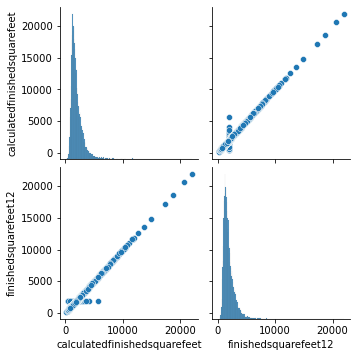

In [24]:
sns.pairplot(data = train[sqft])

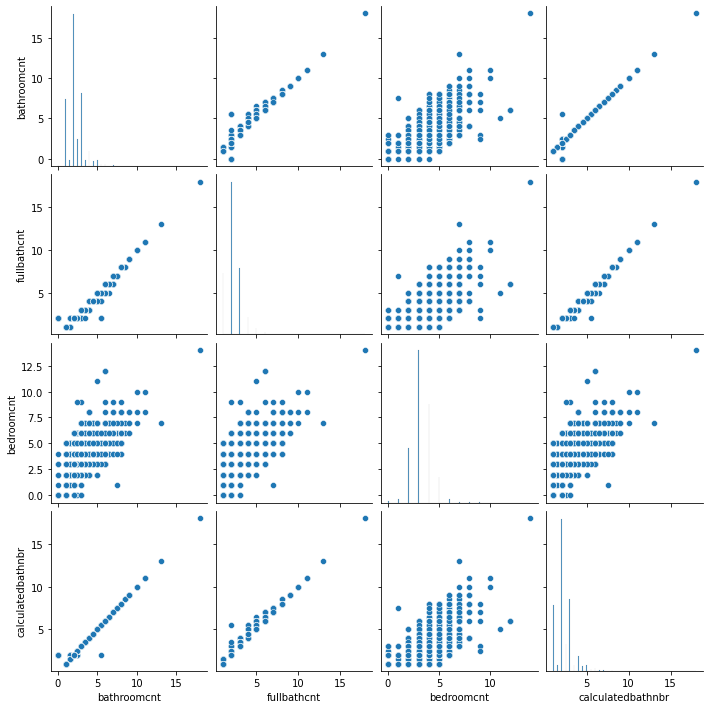

In [25]:
sns.pairplot(data = train[bath])

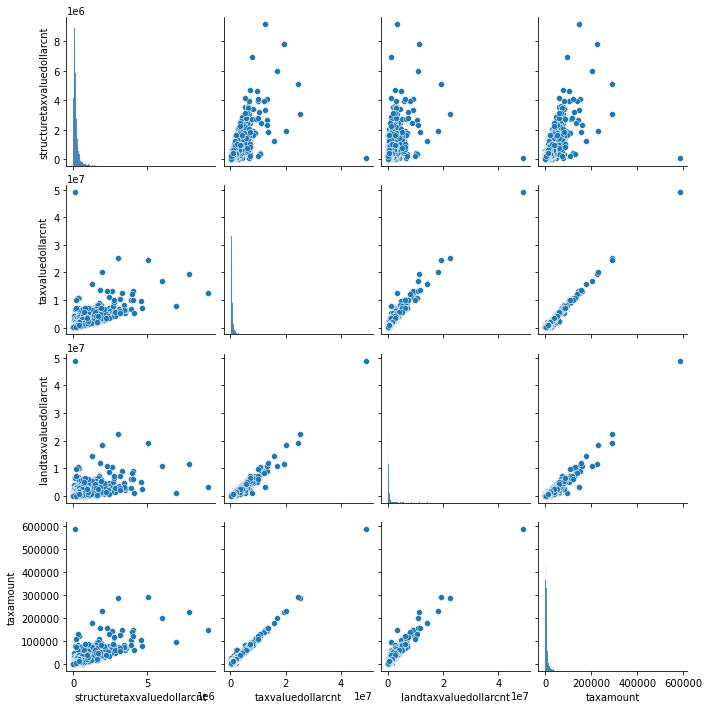

In [26]:
sns.pairplot(data = train[value])

In [27]:
train[sqft].corr()

,calculatedfinishedsquarefeet,finishedsquarefeet12
calculatedfinishedsquarefeet,1.000000,0.998154
finishedsquarefeet12,0.998154,1.000000


In [28]:
train[bath].corr()

,bathroomcnt,fullbathcnt,bedroomcnt,calculatedbathnbr
bathroomcnt,1.000000,0.979873,0.655838,0.994196
fullbathcnt,0.979873,1.000000,0.632890,0.985893
bedroomcnt,0.655838,0.632890,1.000000,0.641502
calculatedbathnbr,0.994196,0.985893,0.641502,1.000000


In [29]:
train[value].corr()

,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount
structuretaxvaluedollarcnt,1.000000,0.763152,0.561042,0.761241
taxvaluedollarcnt,0.763152,1.000000,0.963018,0.992811
landtaxvaluedollarcnt,0.561042,0.963018,1.000000,0.954683
taxamount,0.761241,0.992811,0.954683,1.000000


In [30]:
train[loc].corr()

,latitude,longitude,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,censustractandblock
latitude,1.000000,-0.545260,-0.066339,-0.020766,0.589046,0.012989,-0.066897
longitude,-0.545260,1.000000,-0.370433,0.004893,-0.375625,0.029708,-0.368072
rawcensustractandblock,-0.066339,-0.370433,1.000000,-0.036598,-0.600027,0.035077,0.997099
regionidcity,-0.020766,0.004893,-0.036598,1.000000,0.056517,-0.011431,-0.036372
regionidcounty,0.589046,-0.375625,-0.600027,0.056517,1.000000,-0.043594,-0.599148
regionidzip,0.012989,0.029708,0.035077,-0.011431,-0.043594,1.000000,0.034937
censustractandblock,-0.066897,-0.368072,0.997099,-0.036372,-0.599148,0.034937,1.000000


In [31]:
train.censustractandblock.nunique()

21013

In [36]:
# drop corrlated columns from split data
train = train.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
validate = validate.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))
test = test.drop(columns=(['finishedsquarefeet12', 'landtaxvaluedollarcnt', 'taxamount', 'calculatedbathnbr', 'fullbathcnt']))

In [37]:
print(train.shape, validate.shape, test.shape)

(29442, 22) (12618, 22) (10515, 22)


In [38]:
train.head()

,propertylandusetypeid,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,...,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,censustractandblock,propertylandusedesc
48073,261.0,12146653,-0.012532,2017-06-19,2.0,4.0,1707.0,6037.0,34116665.0,-118018915.0,...,6.037431e+07,50749.0,3101.0,96267.0,0.0,1952.0,216184.0,720620.0,6.037431e+13,Single Family Residential
50249,261.0,12500320,-0.004832,2017-06-23,1.0,2.0,1062.0,6037.0,33813689.0,-118193417.0,...,6.037572e+07,46298.0,3101.0,96240.0,0.0,1942.0,69380.0,346902.0,6.037572e+13,Single Family Residential
23543,261.0,14006290,-0.013975,2017-04-05,2.0,3.0,1703.0,6059.0,33798852.0,-117960559.0,...,6.059088e+07,24832.0,1286.0,97048.0,7.0,1954.0,43063.0,69763.0,6.059088e+13,Single Family Residential
10112,261.0,11893652,-0.043310,2017-02-15,1.0,2.0,1266.0,6037.0,34102240.0,-118122174.0,...,6.037480e+07,50677.0,3101.0,96531.0,0.0,1924.0,228887.0,685772.0,6.037480e+13,Single Family Residential
19637,261.0,11290558,-0.041874,2017-03-23,2.0,3.0,1502.0,6037.0,34683103.0,-118116378.0,...,6.037901e+07,5534.0,3101.0,97318.0,0.0,1978.0,85811.0,114486.0,6.037901e+13,Single Family Residential


***
#### Key Takeaways: 

* calculatedfinishedsquarefeet & finishedsquarefeet12 highly correlated 
    * drop finishedsquarefeet12  
* calculatedbathnbr hihgly correlated with bathroomcnt less so with bedroomcnt
    * going to drop all except bathroomcnt & bedroomcnt 
* taxvaluedollarcount highly correlated with all others in this group     
    * correlation b/w taxvaluedollarcnt & structuretaxvaluedollarcnt weaker, keep these two and drop others       
* Not able to deal w/location features using correlation
       
***

# Feature Engineering

In [39]:
train.corr().sort_values('logerror', ascending=False)

,propertylandusetypeid,parcelid,logerror,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,rawcensustractandblock,regionidcity,regionidcounty,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,censustractandblock
logerror,0.003963,0.008820,1.000000,0.039157,0.045662,0.044302,0.006872,-0.012943,0.017571,0.008989,0.006825,0.004938,-0.017636,0.004335,0.012615,0.017636,0.009564,0.009922,0.006582
bedroomcnt,-0.073739,0.056429,0.045662,0.655838,1.000000,0.626927,0.123968,0.007550,0.005129,0.008596,0.124427,-0.044181,-0.137768,0.025483,0.173069,0.382693,0.373463,0.272500,0.125271
calculatedfinishedsquarefeet,-0.016102,0.056994,0.044302,0.846659,0.626927,1.000000,0.108526,-0.047161,0.001540,0.044601,0.108203,-0.045958,-0.141047,0.030104,0.081714,0.451610,0.763987,0.601421,0.107034
bathroomcnt,-0.036640,0.052523,0.039157,1.000000,0.655838,0.846659,0.104996,-0.023206,0.007356,0.028977,0.104920,-0.048664,-0.143887,0.031354,0.077597,0.521828,0.647014,0.513012,0.104763
yearbuilt,0.027419,0.156971,0.017636,0.521828,0.382693,0.451610,0.292708,0.047185,0.097568,0.036722,0.294762,-0.077578,-0.344778,0.053741,0.187098,1.000000,0.347417,0.164636,0.293544
longitude,-0.082294,-0.048844,0.017571,0.007356,0.005129,0.001540,-0.367436,-0.545260,1.000000,-0.014267,-0.370433,0.004893,-0.375625,0.029708,-0.014668,0.097568,-0.049037,-0.033629,-0.368072
roomcnt,0.006245,0.370542,0.012615,0.077597,0.173069,0.081714,0.738828,-0.285856,-0.014668,-0.011649,0.736820,-0.042679,-0.749377,0.034521,1.000000,0.187098,-0.038802,-0.006169,0.736591
taxvaluedollarcnt,-0.016937,0.015991,0.009922,0.513012,0.272500,0.601421,0.023255,-0.119998,-0.033629,0.024551,0.022443,-0.022958,-0.058306,0.020485,-0.006169,0.164636,0.763152,1.000000,0.022004
structuretaxvaluedollarcnt,-0.017915,0.031144,0.009564,0.647014,0.373463,0.763987,0.065593,-0.038402,-0.049037,0.041107,0.065471,-0.035241,-0.053405,0.017279,-0.038802,0.347417,1.000000,0.763152,0.064606
lotsizesquarefeet,0.004607,-0.009717,0.008989,0.028977,0.008596,0.044601,-0.004746,0.058190,-0.014267,1.000000,-0.004078,-0.009648,0.022652,0.010375,-0.011649,0.036722,0.041107,0.024551,-0.004107


In [43]:
# combine sqft with highly correlated features in order to eliminate noise
train['bedsqft'] = train.bedroomcnt/train.calculatedfinishedsquarefeet
train['bathsqft'] = train.bathroomcnt/train.calculatedfinishedsquarefeet
train['pricesqft'] = train.taxvaluedollarcnt/train.calculatedfinishedsquarefeet

In [ ]:
# Create log quartile column to separate logerror extremes and identify trends
log_quantile = [1,2,3,4]
train['log_quantile'] = pd.qcut(train['logerror'], q=[0,.25,.5,.75,1], labels = log_quantile)

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.yearbuilt, size=train.log_quantile)

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=train, x=train.latitude, y=train.longitude, hue=train.regionidcity)

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.transactiondate, y=df2.logerror, hue=df2.log_quantile)

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.yearbuilt, y=df2.logerror)

In [ ]:
# Assign X to X_train for simplicity
X = X_train

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=df2, x=df2.latitude, y=df2.longitude, hue=df2.censustractandblock)

In [ ]:
# Distribution of Assessed Values
X.landtaxvaluedollarcnt.describe()

In [ ]:
plt.figure(figsize=(16, 15))
sns.scatterplot(data=X, x=X.latitude, y=X.longitude, hue=X.logerror)

In [ ]:
X.logerror.describe()

In [ ]:
X.info()